<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

In [ ]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [ ]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [ ]:
from google.colab import drive

drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create array with Path objects to imgs

In [ ]:
path = Path(f"{dataset_path}")

In [ ]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

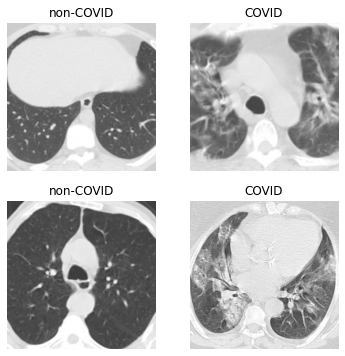

In [ ]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

## Inference

Load the model from URL

In [ ]:

res34 = load_learner(f'{folder_path}res34.pkl')
res34_con = load_learner(f'{folder_path}res34_con.pkl')
res34_noise = load_learner(f'{folder_path}res34_noise.pkl')


"\nres34 = load_learner(f'{folder_path}res34.pkl')\nres34_con = load_learner(f'{folder_path}res34_con.pkl')\nres34_noise = load_learner(f'{folder_path}res34_noise.pkl')\n"

In [ ]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    self.model_list = []
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      self.model_list.append(model)
      print(f'loaded: {name}')
  
  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p.numpy())
    
    probas = np.stack(probas, axis=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for model in self.model_list:
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res


In [ ]:
en = Ensemble(dls.valid, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=['non-covid', 'covid'])
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-covid', 'covid']
loaded: res34
loaded: res34_con
loaded: res34_noise


In [ ]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('covid',
 array([0.48382664, 0.51617336], dtype=float32),
 array([0.3905154 , 0.39051542], dtype=float32))

In [ ]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0312, 0.9688]))

In [ ]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

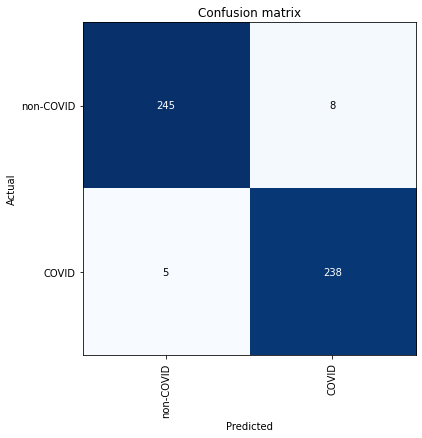

In [ ]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) -> calls get_preds
interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

{'F1Score': 0.9734151329243353, 'Recall': 0.9794238683127572}

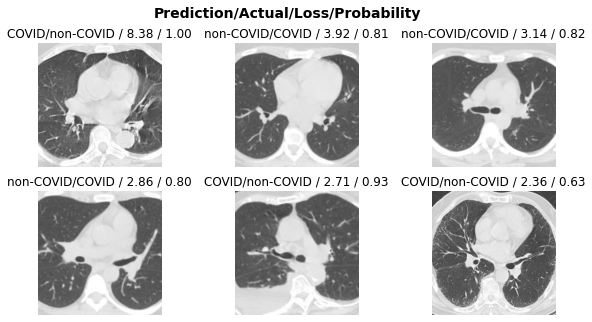

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU" -O res34.pkl && rm -rf /tmp/cookies.txt &> 2

--2021-12-17 21:28:28--  https://docs.google.com/uc?export=download&confirm=JF&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU
Resolving docs.google.com (docs.google.com)... 64.233.187.138, 64.233.187.113, 64.233.187.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.187.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘res34.pkl’

res34.pkl               [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-12-17 21:28:28 (32.0 MB/s) - ‘res34.pkl’ saved [3296]

